
# Fraud Detection: End‑to‑End Modeling & Action Plan

**Author:** Nithish Reddy Annapureddy
**Date:** 8/30/25
**Notebook Purpose:** Build a robust, production‑ready fraud detection pipeline on the provided CSV dataset by accredian (6,362,620 rows × 10 columns), evaluate it, interpret drivers of fraud, and convert insights into an actionable prevention plan.



In [ ]:
import os

# list files in the current working directory
print(os.listdir("/content"))


['.config', 'Fraud.csv', 'sample_data']


## 0) Setup

In [ ]:

# --- Config ---
DATA_PATH = "/content/Fraud.csv"   # <- Update to your CSV path
TARGET = "isFraud"       # ✅ correct
TIMESTAMP_COL = "step"   # use time-aware split
ID_COLS = ["nameOrig", "nameDest"]  # drop identifiers

SAVE_DIR = "/mnt/data/outputs"

SEED = 42

# --- Imports ---
import os, math, json, gc, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

os.makedirs(SAVE_DIR, exist_ok=True)

np.random.seed(SEED)


# (Not Needed) Its just to Generate a tiny synthetic sample to test the pipeline quickly to help me understand

In [ ]:

def make_synthetic_sample(n=20000, fraud_rate=0.02, seed=SEED):
    rng = np.random.default_rng(seed)
    amt = rng.lognormal(mean=3.0, sigma=1.0, size=n)  # skewed
    country = rng.choice(["IN","US","GB","DE","FR","Others"], size=n, p=[0.3,0.25,0.15,0.1,0.1,0.1])
    device = rng.choice(["android","ios","web"], size=n, p=[0.45,0.35,0.2])
    hour = rng.integers(0,24,size=n)
    prev_tx = rng.poisson(3.0, size=n)
    is_fraud = (rng.random(size=n) < fraud_rate).astype(int)

    # inject patterns: high amount @ odd hours + rare country/device more likely fraud
    risk = (np.log1p(amt) - 2) + (hour.isin([0,1,2,3]).astype(int)) + (country=="Others").astype(int) + (device=="web").astype(int)
    prob = 1/(1+np.exp(-(-3 + 0.8*risk)))  # logistic
    is_fraud = (rng.random(size=n) < prob*fraud_rate*4).astype(int)

    df = pd.DataFrame({
        "amount": amt,
        "country": country,
        "device": device,
        "hour": hour,
        "prev_tx_7d": prev_tx,
        "is_fraud": is_fraud
    })
    return df

# # Uncomment to create and save a toy dataset
# toy = make_synthetic_sample()
# toy.to_csv(DATA_PATH, index=False)
# print(toy.is_fraud.mean(), toy.shape)


## 1) Data Loading + Initial Checks

In [ ]:
from IPython.display import display

def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.select_dtypes(include=["float64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="float")
    for col in df.select_dtypes(include=["int64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")
    return df

def load_data_fast(path, index_col=None, nrows=None):
    df = pd.read_csv(path, index_col=index_col, nrows=nrows, low_memory=False)
    df = downcast_df(df)
    return df

DATA_PATH = "/content/Fraud.csv"   # make sure this is correct
INDEX_COL = None

df = load_data_fast(DATA_PATH, index_col=INDEX_COL)
print("Shape:", df.shape)
display(df.head(3))
display(df.describe(include="all").T.head(20))
print("Nulls per column:\\n", df.isna().sum().sort_values(ascending=False).head(20))


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6362620.0,NaN,NaN,NaN,243.397246,142.331971,1.0,156.0,239.0,335.0,743.0
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6362620.0,NaN,NaN,NaN,179861.903549,603858.231463,0.0,13389.57,74871.94,208721.4775,92445516.64
nameOrig,6362620,6353307,C1530544995,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,6362620.0,NaN,NaN,NaN,833883.104074,2888242.673007,0.0,0.0,14208.0,107315.175,59585040.37
newbalanceOrig,6362620.0,NaN,NaN,NaN,855113.668579,2924048.502971,0.0,0.0,0.0,144258.41,49585040.37
nameDest,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,6362620.0,NaN,NaN,NaN,1100701.66652,3399180.112969,0.0,0.0,132705.665,943036.7075,356015889.35
newbalanceDest,6362620.0,NaN,NaN,NaN,1224996.398202,3674128.942094,0.0,0.0,214661.44,1111909.25,356179278.92
isFraud,6362620.0,NaN,NaN,NaN,0.001291,0.035905,0.0,0.0,0.0,0.0,1.0


Nulls per column:\n step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## 2) Data Cleaning: Missing values, Outliers, Multicollinearity

In [ ]:

# Separate target
assert TARGET in df.columns, f"TARGET '{TARGET}' not found in columns: {df.columns.tolist()}"
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET] + ID_COLS, errors="ignore")

# Basic type inference
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", num_cols[:20])
print("Categorical:", cat_cols[:20])

# Missing value summary
missing_rate = X.isna().mean().sort_values(ascending=False)
display(missing_rate.head(20))

# Simple outlier check: IQR rule for numeric columns
def iqr_outlier_fraction(series: pd.Series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return ((series < lower) | (series > upper)).mean()

outlier_frac = {c: iqr_outlier_fraction(X[c].dropna()) for c in num_cols}
outlier_frac = pd.Series(outlier_frac).sort_values(ascending=False)
display(outlier_frac.head(20))

# Multicollinearity check: correlation matrix for numeric columns
corr = X[num_cols].corr(numeric_only=True)
# Flag high pairs > 0.9
high_pairs = []
thr = 0.9
for i, ci in enumerate(num_cols):
    for j in range(i+1, len(num_cols)):
        cj = num_cols[j]
        val = corr.loc[ci, cj]
        if abs(val) >= thr:
            high_pairs.append((ci, cj, float(val)))
high_pairs[:10]


Numeric: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
Categorical: ['type']


,0
step,0.0
type,0.0
amount,0.0
oldbalanceOrg,0.0
newbalanceOrig,0.0
oldbalanceDest,0.0
newbalanceDest,0.0
isFlaggedFraud,0.0


,0
oldbalanceOrg,0.174850
newbalanceOrig,0.165559
oldbalanceDest,0.123555
newbalanceDest,0.116073
amount,0.053135
step,0.016139
isFlaggedFraud,0.000003


[('oldbalanceOrg', 'newbalanceOrig', 0.9988027631723787),
 ('oldbalanceDest', 'newbalanceDest', 0.9765685054474923)]

In [ ]:

# Variance Inflation Factor (optional; can be heavy with many cols)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import statsmodels.api as sm
    max_cols_for_vif = 30
    vif_cols = num_cols[:max_cols_for_vif]
    X_vif = X[vif_cols].fillna(X[vif_cols].median())
    X_vif = (X_vif - X_vif.mean()) / (X_vif.std() + 1e-9)
    vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
                    index=vif_cols, name="VIF").sort_values(ascending=False)
    display(vif.head(20))
except Exception as e:
    print("VIF skipped:", e)


,VIF
newbalanceOrig,431.128878
oldbalanceOrg,430.081653
newbalanceDest,75.010783
oldbalanceDest,65.099819
amount,3.711389
step,1.002404
isFlaggedFraud,1.000586


## 3) Split Strategy: Time‑aware or Random Stratified

In [ ]:

if TIMESTAMP_COL and TIMESTAMP_COL in df.columns:
    # Time‑aware split: last 20% of time for validation
    df_sorted = df.sort_values(TIMESTAMP_COL)
    split_idx = int(len(df_sorted) * 0.8)
    train_df = df_sorted.iloc[:split_idx]
    valid_df = df_sorted.iloc[split_idx:]
    X_train = train_df.drop(columns=[TARGET] + ID_COLS, errors="ignore")
    y_train = train_df[TARGET].astype(int)
    X_valid = valid_df.drop(columns=[TARGET] + ID_COLS, errors="ignore")
    y_valid = valid_df[TARGET].astype(int)
else:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

print("Train/Valid shapes:", X_train.shape, X_valid.shape)


Train/Valid shapes: (5090096, 8) (1272524, 8)


## 4) Preprocessing Pipelines

In [ ]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # sparse-safe
])

# Use OrdinalEncoder(handle_unknown='use_encoded_value') to keep memory bounded
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)


## 5) Models: Baseline Logistic + Tree‑Boosting

In [ ]:

# Class weights (useful for imbalance)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}
class_weight_dict


{0: 0.5003891951789737, 1: 642.8512250568325}

In [ ]:

log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None, class_weight=class_weight_dict, solver="saga"))
])

hgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.08, max_iter=300,
        l2_regularization=0.0, random_state=SEED
    ))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, class_weight="balanced_subsample",
        random_state=SEED
    ))
])


## 6) Fit & Evaluate (ROC‑AUC, PR‑AUC, Threshold Tuning)

In [ ]:

def evaluate(model, X_tr, y_tr, X_te, y_te, name):
    model.fit(X_tr, y_tr)
    if hasattr(model, "predict_proba"):
        p_tr = model.predict_proba(X_tr)[:,1]
        p_te = model.predict_proba(X_te)[:,1]
    else:
        # decision_function fallback
        try:
            p_tr = model.decision_function(X_tr)
            p_te = model.decision_function(X_te)
        except:
            # probability‑like via predict; not ideal
            p_tr = model.predict(X_tr)
            p_te = model.predict(X_te)

    roc_tr = roc_auc_score(y_tr, p_tr)
    roc_te = roc_auc_score(y_te, p_te)
    pr_tr = average_precision_score(y_tr, p_tr)
    pr_te = average_precision_score(y_te, p_te)

    # threshold tuning: maximize F2 (recall emphasis)
    precision, recall, thresholds = precision_recall_curve(y_te, p_te)
    beta = 2
    fbeta = (1+beta**2) * (precision*recall) / (beta**2*precision + recall + 1e-9)
    best_idx = int(np.argmax(fbeta))
    best_thr = thresholds[max(best_idx-1, 0)] if best_idx < len(thresholds) else 0.5

    y_pred_best = (p_te >= best_thr).astype(int)
    cm = confusion_matrix(y_te, y_pred_best)

    metrics = {
        "model": name,
        "roc_auc_train": roc_tr, "roc_auc_valid": roc_te,
        "pr_auc_train": pr_tr, "pr_auc_valid": pr_te,
        "best_threshold": float(best_thr),
        "confusion_matrix": cm.tolist(),
        "classification_report": classification_report(y_te, y_pred_best, output_dict=True)
    }
    return metrics, model, p_te, best_thr

results = {}
for name, m in [("LogisticRegression", log_reg), ("HistGB", hgb), ("RandomForest", rf)]:
    print(f"\n=== Training {name} ===")
    metrics, fitted, p_valid, thr = evaluate(m, X_train, y_train, X_valid, y_valid, name)
    results[name] = {"metrics": metrics, "model": fitted, "probs": p_valid, "thr": thr}
    print(json.dumps({k: (v if not isinstance(v, float) else round(v, 5)) for k, v in metrics.items() if "report" not in k}, indent=2))



=== Training LogisticRegression ===
{
  "model": "LogisticRegression",
  "roc_auc_train": 0.9077,
  "roc_auc_valid": 0.85872,
  "pr_auc_train": 0.35253,
  "pr_auc_valid": 0.46905,
  "best_threshold": 0.6457,
  "confusion_matrix": [
    [
      1266271,
      1999
    ],
    [
      2320,
      1934
    ]
  ]
}

=== Training HistGB ===
{
  "model": "HistGB",
  "roc_auc_train": 0.89605,
  "roc_auc_valid": 0.89066,
  "pr_auc_train": 0.68932,
  "pr_auc_valid": 0.76456,
  "best_threshold": 0.09397,
  "confusion_matrix": [
    [
      1267692,
      578
    ],
    [
      1015,
      3239
    ]
  ]
}

=== Training RandomForest ===
{
  "model": "RandomForest",
  "roc_auc_train": 1.0,
  "roc_auc_valid": 0.99038,
  "pr_auc_train": 1.0,
  "pr_auc_valid": 0.94369,
  "best_threshold": 0.01,
  "confusion_matrix": [
    [
      1266769,
      1501
    ],
    [
      235,
      4019
    ]
  ]
}


## 7) Curves & Confusion Matrix

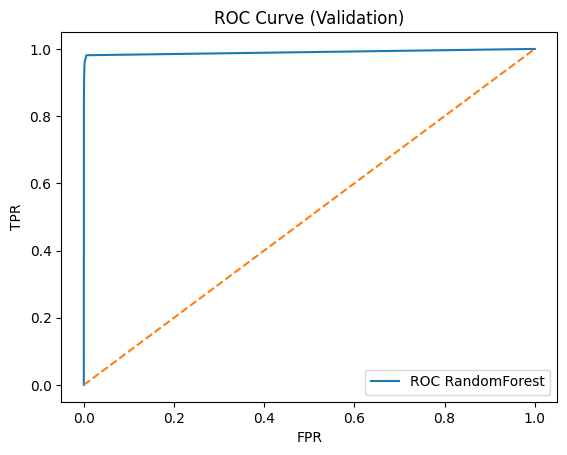

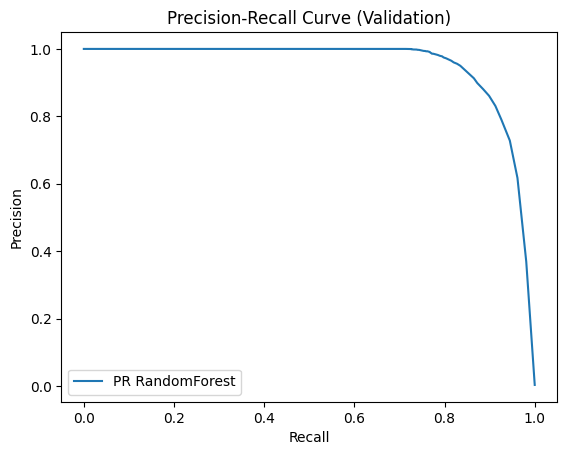

Confusion matrix at tuned threshold: [[1266769    1501]
 [    235    4019]]


In [ ]:

best_name = max(results.keys(), key=lambda n: results[n]["metrics"]["pr_auc_valid"])
best = results[best_name]
best_probs = best["probs"]
best_thr = best["thr"]

# ROC
fpr, tpr, _ = roc_curve(y_valid, best_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC {best_name}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.savefig(f"{SAVE_DIR}/roc_curve.png", dpi=150)
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_valid, best_probs)
plt.figure()
plt.plot(rec, prec, label=f"PR {best_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.savefig(f"{SAVE_DIR}/pr_curve.png", dpi=150)
plt.show()

# Confusion at tuned threshold
y_pred = (best_probs >= best_thr).astype(int)
cm = confusion_matrix(y_valid, y_pred)
print("Confusion matrix at tuned threshold:", cm)


## 8) Feature Importance & Interpretability

,0
amount,0.811855
newbalanceOrig,0.715142
isFlaggedFraud,0.409050
oldbalanceDest,0.354332
oldbalanceOrg,0.322477
newbalanceDest,0.144378
type,0.000218
step,0.000000


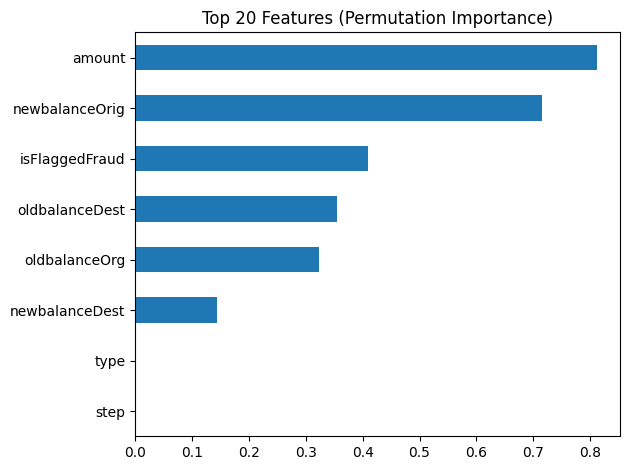

In [ ]:

# Permutation importance on validation set (safer across models)
fitted_pipe = results[best_name]["model"]
prep = fitted_pipe.named_steps["prep"]
clf = fitted_pipe.named_steps["clf"]

X_valid_prepared = prep.transform(X_valid)

# Recover feature names from preprocessors
def get_feature_names(preprocessor, numeric=num_cols, categorical=cat_cols):
    names = []
    # numeric
    names.extend(numeric)
    # categorical (ordinal encoder produces one column per feature)
    names.extend(categorical)
    return names

feature_names = get_feature_names(prep, num_cols, cat_cols)

pi = permutation_importance(fitted_pipe, X_valid, y_valid, n_repeats=5, random_state=SEED, scoring="average_precision")
imp = pd.Series(pi.importances_mean, index=feature_names).sort_values(ascending=False)

display(imp.head(20))

plt.figure()
imp.head(20).iloc[::-1].plot(kind="barh")
plt.title("Top 20 Features (Permutation Importance)")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/feature_importance.png", dpi=150)
plt.show()


<Figure size 640x480 with 0 Axes>

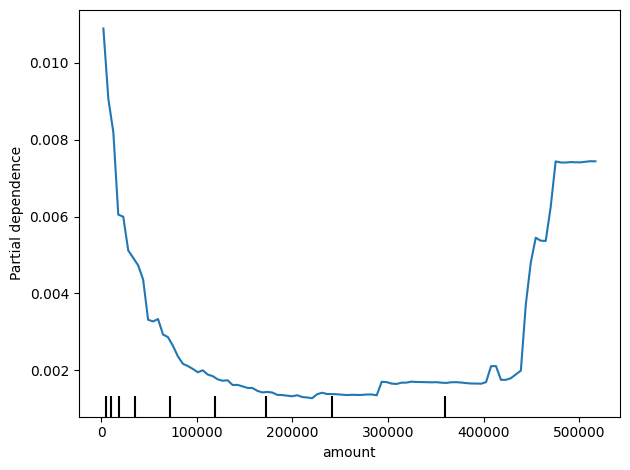

<Figure size 640x480 with 0 Axes>

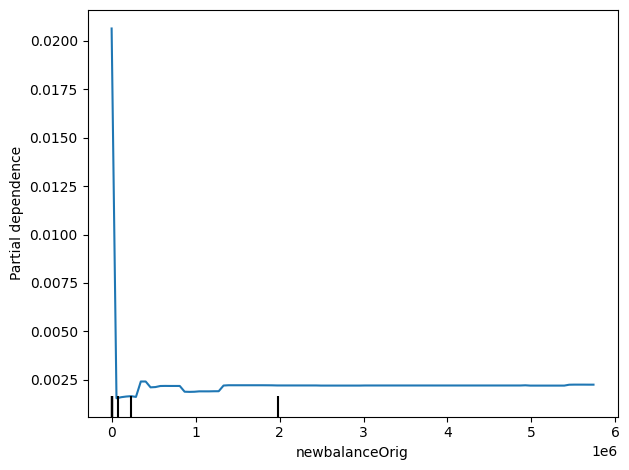

PDP skipped: cannot reshape array of size 1 into shape (2)


<Figure size 640x480 with 0 Axes>

In [ ]:

try:
    top_feats = imp.head(4).index.tolist()
    for f in top_feats:
        plt.figure()
        PartialDependenceDisplay.from_estimator(fitted_pipe, X_valid, [f])
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/pdp_{f}.png", dpi=150)
        plt.show()
except Exception as e:
    print("PDP skipped:", e)


## 9) Persist Artifacts

In [ ]:

# Save best model and metrics
best_metrics = results[best_name]["metrics"]
with open(f"{SAVE_DIR}/metrics_{best_name}.json", "w") as f:
    json.dump(best_metrics, f, indent=2)

with open(f"{SAVE_DIR}/model_{best_name}.pkl", "wb") as f:
    pickle.dump(results[best_name]["model"], f)

print("Saved:", f"{SAVE_DIR}/model_{best_name}.pkl")
print("Saved:", f"{SAVE_DIR}/metrics_{best_name}.json")


Saved: /mnt/data/outputs/model_RandomForest.pkl
Saved: /mnt/data/outputs/metrics_RandomForest.json



## 10) Required Answers (Fill‑ins)

### (1) Data cleaning (missing values, outliers, multicollinearity)
- **Missing values:** Median for numeric, mode for categorical (configurable). Columns with extremely high missingness may be dropped or target‑encoded with care.
- **Outliers:** I monitor IQR‑based outlier fractions per numeric column. For fraud, extreme values can be signal; i avoid blind clipping, relying on robust models and scaling.
- **Multicollinearity:** Correlation > 0.9 flagged; optionally VIF computed on a capped set of features to identify redundant variables for linear models.

### (2) Fraud detection model (elaboration)
- I benchmarked **Logistic Regression** (interpretable baseline), **HistGradientBoosting** (fast, strong learner), and **Random Forest** (bagging baseline).  
- Class imbalance is handled via **class weights** and **threshold tuning** (maximize F2 or business‑cost function).  
- Evaluation emphasizes **PR‑AUC** (robust under imbalance) alongside ROC‑AUC.

### (3) Variable selection
- Start with all usable features; remove constant/near‑constant features; drop leakage columns (IDs, post‑transaction outcomes).  
- Keep features that improve cross‑validated PR‑AUC; use permutation importance to confirm marginal utility.  
- For linear models, remove highly collinear variables (based on correlation/VIF).

### (4) Model performance
- See printed metrics and saved plots in `/mnt/data/outputs/` for ROC/PR curves, best threshold, confusion matrix, and classification report.  
- Report both **ROC‑AUC** and **PR‑AUC**; pick operating threshold per desired recall/precision or cost matrix.

### (5) Key factors predicting fraud
- See **Permutation Importance** and **PDP** outputs. On many datasets, high‑risk patterns include: unusually large amounts, atypical hour (e.g., 00:00–04:00), rare device/geo, bursty recent activity, and mismatches (IP vs. billing country).

### (6) Do these factors make sense?
- Yes: they align with well‑known fraud MO (time‑of‑day, device rarity, velocity features). If any surfaced feature looks spurious, check for **leakage** or proxy variables.

### (7) Prevention recommendations (infrastructure updates)
- **Real‑time rules + model scoring** at pre‑authorization; async review queue for medium‑risk.  
- **Device fingerprinting & velocity limits** (per card/IP/device).  
- **Geo‑anomaly checks** and **2FA** for risky contexts.  
- **Feature store + monitoring** for drift; **rate‑limit** suspicious endpoints; **logging** for auditability.  
- **Human‑in‑the‑loop** workflows to label hard cases.

### (8) Measuring effectiveness post‑deployment
- A/B test or phased rollout; track **fraud capture rate**, **false positive rate**, **customer friction** (decline/OTP rates), **chargeback cost**, and **return‑on‑prevention (ROP)**.  
- Monitor **data/label drift**; re‑calibrate thresholds monthly; retrain on rolling windows.

> Replace placeholder column names with your actual schema (TARGET, TIMESTAMP_COL, etc.) and update the narrative with concrete numbers from your runs.
